# Convert json to CSV to work with Gephi for better visualization

In [ ]:
import pandas as pd
import json

data = pd.read_json("50kwithPaths.json", lines=True)

print("DataFrame columns:", data.columns)

nodes_list = []
relationships_list = []

for _, row in data.iterrows():
    path = row['path']
    
    if not isinstance(path, dict) or 'nodes' not in path or 'relationships' not in path:
        continue
    
    for node in path['nodes']:
        node_data = {
            'id': node['id'],
            'type': node['type'],
            'labels': ','.join(node['labels']),
            **node['properties']  # Unpack all properties
        }
        nodes_list.append(node_data)
    
    for rel in path['relationships']:
        rel_data = {
            'id': rel['id'],
            'start_node': rel['start'],
            'end_node': rel['end'],
            'label': rel['label'],
            **rel['properties']  
        }
        relationships_list.append(rel_data)

nodes_df = pd.DataFrame(nodes_list).drop_duplicates(subset=['id'])
relationships_df = pd.DataFrame(relationships_list).drop_duplicates(subset=['id'])

relationships_df['source'] = relationships_df['start_node']
relationships_df['target'] = relationships_df['end_node']

In [ ]:
nodes_df.to_csv('nodes.csv', index=False)
relationships_df.to_csv(edges.csv', index=False)

In [ ]:
print("Nodes DataFrame:")
print(nodes_df.head())
print("\nRelationships DataFrame:")
print(relationships_df.head())

# Calculating new features to use in Gephi based on CSV's and json

### Features to extend nodes CSV

In [1]:
import pandas as pd
import json

nodes_df = pd.read_csv("nodes.csv.xls")

json_file_path = "usr_app_tag_63k.json"
with open(json_file_path, "r", encoding="utf-8") as f:
    json_lines = f.readlines()
json_data = [json.loads(line) for line in json_lines]
json_df = pd.DataFrame(json_data)

edges_df = pd.read_csv("edges.csv.xls")
edges_df['zero_played'] = edges_df['playtime'] == 0

App features like zero_playtime (= users with 0 playtime/total users) and app_avg_playtime (=avg playtime over all users) based on the relations in the json file + add them to the node csv at the right place

In [4]:
app_nodes = nodes_df[(nodes_df['labels'] == 'App') & (nodes_df['name'].notna())].copy()
json_lookup = json_df.set_index('app_name')[['zero_playtime_owners', 'avg_playtime']]
app_nodes = app_nodes.merge(json_lookup, how='left', left_on='name', right_index=True)
app_nodes.rename(columns={
    'zero_playtime_owners': 'app_zero_playtime',
    'avg_playtime': 'app_avg_playtime'
}, inplace=True)

Calculate user futures like user_zero_playtime_ratio (= not played games / totale games owned) and relationship strenght (= 1/total apps owned) based on the numbers in edges 

In [7]:
user_play_stats = edges_df.groupby('start_node').agg(
    owned_apps_count=('playtime', 'count'),
    zero_played_apps=('zero_played', 'sum'),
    user_avg_playtime=('playtime', 'mean')
).reset_index()
user_play_stats['user_zero_playtime_ratio'] = user_play_stats['zero_played_apps'] / user_play_stats['owned_apps_count']
user_play_stats['user_relationship_strength'] = 1 / user_play_stats['owned_apps_count']

Add new features to the right nodes with label = user

In [10]:
user_nodes = nodes_df[nodes_df['labels'] == 'User'].copy()
user_nodes = user_nodes.merge(user_play_stats, how='left', left_on='id', right_on='start_node')
user_nodes.drop(columns=['start_node'], inplace=True)

Combine the new user node and app nodes in a new dataframe

In [13]:
other_nodes = nodes_df[~nodes_df['id'].isin(app_nodes['id']) & ~nodes_df['id'].isin(user_nodes['id'])]
combined_df = pd.concat([app_nodes, user_nodes, other_nodes], ignore_index=True)

Make a column nametag to filter on in Gephi (one uniform column for both user and app nodes)

In [16]:
combined_df['nametag'] = combined_df['personaname'].combine_first(combined_df['name'])

Export a clean version

In [19]:
filtered_final_df = combined_df[
    (combined_df['nametag'].notna()) &
    (combined_df['labels'].isin(['App', 'User']))
].copy()

filtered_final_df.to_csv("nodes_final.csv", index=False)

### Features to extend edges CSV

Implement variable binary_played (= 1 if the game is played) to determine the difference between played and non played relationships

In [23]:
edges_df['binary_played'] = (edges_df['playtime'] > 0).astype(int)

Calculation of edge_weight (=user_relationship_strength * playtime) to show the importance of a relation: more important = less apps and higher playtime

In [26]:
user_strength_df = pd.read_csv("nodes_final.csv")
user_strength_lookup = user_strength_df[user_strength_df['labels'] == 'User'][['id', 'user_relationship_strength']]

edges_enriched = edges_df.merge(user_strength_lookup, how='left', left_on='start_node', right_on='id')

edges_enriched['edge_weight'] = edges_enriched['user_relationship_strength'] * edges_enriched['playtime']

edges_enriched.drop(columns=['id_y'], inplace=True)
edges_enriched.rename(columns={'id_x': 'id'}, inplace=True)

C:\Users\guuss\AppData\Local\Temp\ipykernel_18648\1527170349.py:1: DtypeWarning: Columns (3,7,10,11,12,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  user_strength_df = pd.read_csv("nodes_final.csv")


In [30]:
edges_enriched.to_csv("edges_final.csv", index=False)

### Calculate 'backlog' users/apps based on the 0.8 threshold, defined in the first look

For app_backlog: calculate ratio and investigate a good threshold

C:\Users\guuss\AppData\Local\Temp\ipykernel_18648\4115125182.py:5: DtypeWarning: Columns (3,7,10,11,12,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv("nodes_final.csv")


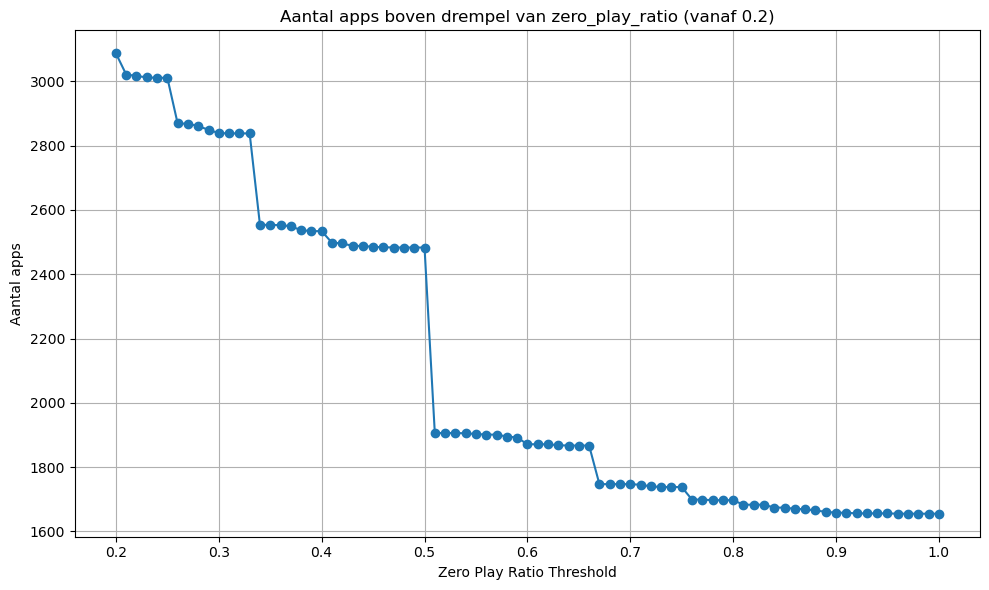

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nodes_df = pd.read_csv("nodes_final.csv")
edges_df = pd.read_csv("edges_final.csv")

apps = nodes_df[(nodes_df['labels'] == 'App') & (nodes_df['app_zero_playtime'].notna())].copy()
app_owners_count = edges_df.groupby('end_node').size().reset_index(name='total_owners')
apps = apps.merge(app_owners_count, how='left', left_on='id', right_on='end_node')
apps = apps[apps['total_owners'] > 0].copy()
apps['zero_play_ratio'] = apps['app_zero_playtime'] / apps['total_owners']

thresholds = np.linspace(0.2, 1, 81)
app_counts = [(apps['zero_play_ratio'] >= t).sum() for t in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, app_counts, marker='o')
plt.title('Aantal apps boven drempel van zero_play_ratio (vanaf 0.2)')
plt.xlabel('Zero Play Ratio Threshold')
plt.ylabel('Aantal apps')
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
t_app_ratio_threshold = 0.4
apps['app_backlog'] = (apps['zero_play_ratio'] >= t_app_ratio_threshold).astype(int)

nodes_df = nodes_df.merge(apps[['id', 'app_backlog']], how='left', on='id')
nodes_df['app_backlog'] = nodes_df.apply(
    lambda row: row['app_backlog'] if row['labels'] == 'App' else pd.NA,
    axis=1
)

For user backlog: use ratio of 0.8 (as seen in other notebook)

In [71]:
nodes_df['user_backlog'] = nodes_df.apply(
    lambda row: 1 if row['labels'] == 'User' and pd.notna(row.get('user_zero_playtime_ratio')) and row['user_zero_playtime_ratio'] >= 0.8 else (0 if row['labels'] == 'User' else pd.NA),
    axis=1
)

Universal backlog binary for Gephi

In [74]:
nodes_df['is_backlog'] = nodes_df.apply(
    lambda row: 1 if (pd.notna(row.get('user_backlog')) and row.get('user_backlog') == 1) or 
                     (pd.notna(row.get('app_backlog')) and row.get('app_backlog') == 1) else 0,
    axis=1
)

Controle:

In [77]:
app_backlog_count = nodes_df['app_backlog'].sum(skipna=True)
user_backlog_count = nodes_df['user_backlog'].sum(skipna=True)
is_backlog_total = nodes_df['is_backlog'].sum()

print("Aantal apps met app_backlog = 1:", app_backlog_count)
print("Aantal users met user_backlog = 1:", user_backlog_count)
print("Totaal aantal nodes met is_backlog = 1:", is_backlog_total)

Aantal apps met app_backlog = 1: 2800.0
Aantal users met user_backlog = 1: 647
Totaal aantal nodes met is_backlog = 1: 3447


In [79]:
nodes_final3_path = "nodes_final3.csv"
nodes_df.to_csv(nodes_final3_path, index=False)

In [82]:
nodes_df.head()

,id,type,labels,avatar,commentpermission,communityvisibilitystate,ident,personaname,personastate,profilestate,...,app_avg_playtime,owned_apps_count,zero_played_apps,user_avg_playtime,user_zero_playtime_ratio,user_relationship_strength,nametag,app_backlog,user_backlog,is_backlog
0,983203,node,App,NaN,NaN,NaN,1662770,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,UFO: Extraterrestrials Platinum,1.0,<NA>,1
1,984076,node,App,NaN,NaN,NaN,1164470,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,[MISC] TIMELINES,0.0,<NA>,0
2,984073,node,App,NaN,NaN,NaN,1119770,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,VaporFly,0.0,<NA>,0
3,984072,node,App,NaN,NaN,NaN,962240,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Tiger Tank 59 Ⅰ A-Gun,0.0,<NA>,0
4,984070,node,App,NaN,NaN,NaN,912590,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,The path to domination,0.0,<NA>,0


## Add the descriptives of the json files like zero_playtime_owners, total_owners to indicate importance of an app

Impute (relative low) values for user nodes, because if we filter on these variables in Gephi all the nodes with nan will disappear

In [89]:
import pandas as pd
import json

nodes_df = pd.read_csv("nodes_final4_cleaned.csv")

with open("usr_app_tag_63k.json", "r", encoding="utf-8") as f:
    json_lines = f.readlines()
json_data = [json.loads(line) for line in json_lines]
json_df = pd.DataFrame(json_data)

apps_only = nodes_df[nodes_df['labels'] == 'App'][['id', 'name']]
apps_merged = apps_only.merge(json_df[['app_name', 'total_owners', 'zero_playtime_owners', 'avg_playtime']],
                               how='left', left_on='name', right_on='app_name')

nodes_df = nodes_df.merge(apps_merged[['id', 'total_owners', 'zero_playtime_owners', 'avg_playtime']],
                          how='left', on='id')

q25_total_owners = nodes_df.loc[nodes_df['labels'] == 'App', 'total_owners'].quantile(0.25)
q25_zero_playtime = nodes_df.loc[nodes_df['labels'] == 'App', 'zero_playtime_owners'].quantile(0.25)
q25_avg_playtime = nodes_df.loc[nodes_df['labels'] == 'App', 'avg_playtime'].quantile(0.25)

nodes_df.loc[nodes_df['labels'] == 'User', 'total_owners'] = q25_total_owners
nodes_df.loc[nodes_df['labels'] == 'User', 'zero_playtime_owners'] = q25_zero_playtime
nodes_df.loc[nodes_df['labels'] == 'User', 'avg_playtime'] = q25_avg_playtime

nodes_df.to_csv("nodes_final5.csv", index=False)

C:\Users\guuss\AppData\Local\Temp\ipykernel_18648\167869272.py:4: DtypeWarning: Columns (3,7,10,11,12,14,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv("nodes_final4_cleaned.csv")
